<a href="https://colab.research.google.com/github/Gabriellanaro/02450_exam/blob/master/social_graphs_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction


This notebook is meant to be an explainer for the Social graphs and interactions (02805) course final project. For more information, goals, the detailed study, and results check out the main paper.

## Imports


In [16]:
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from requests.exceptions import RequestException
from urllib.parse import quote
from bs4 import BeautifulSoup

import community as community_louvain
import matplotlib.pyplot as plt
import urllib.request
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import requests
import warnings
import zipfile
import pickle
import shutil
import ast
import csv
import re
import os

# Ignore InsecureRequestWarning
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

## Data Collection


The hardest part of our study seemed to get our data from the [Cookipedia](https://www.cookipedia.co.uk/recipes_wiki/Welcome_to_Cookipedia) website, and cleaning and structuring it in a way that it suits our goals. In this first section we will explain and reason our choices behind making our dataframe. The first issue we encountered was that altough Cookipedia is structured just like [Wikipedia](https://www.wikipedia.org/), and uses the standard [MediaWiki Action API](https://www.mediawiki.org/wiki/API:Main_page), it has no specific documentation, so we had to figure out how to query our data, especially category based queries, through trial and error and contrasting it with other similar API documentations. This was extremely tedious and time consuming.

In this code block you can see how a query is performed to get one recipe, from the almost 4 thousand recipes found the page. Of course this data needs a lot of further processing, and you can also see that the title is in a specific format, but more on that later.



In [ ]:
title = "Byrek_me_spinaq_(Spinach_pie)"
baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
query_title = "titles=" + title
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}{}&{}&{}&{}".format(baseurl, action, query_title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

Byrek_me_spinaq_(Spinach_pie)
https://en.cookipedia.co.uk/wiki/api.php?action=query&titles=Byrek_me_spinaq_(Spinach_pie)&prop=revisions&rvprop=content&format=json


In order to structure our data into categories, based on **countries**, we had to get the list of countries that Cookipedia uses. After finding out a way to query the countries list, we extracted countries, with a regex, based on the raw response. We get a total of **54** countries (altough some are regions rather then countries). We sore them in an array for later use.

In [ ]:
baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
title = "titles=" + quote("Template:CategoryRecipesCountry")
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}&{}&{}&{}".format(baseurl, action, title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

pattern = r"\[\[:Category:([^|\]]+)\|"

# Find all matches
countries = re.findall(pattern, wikitext)

https://www.cookipedia.co.uk/wiki/api.php?&action=query&titles=Template%3ACategoryRecipesCountry&prop=revisions&rvprop=content


Now based on the *countries* array we build the *recipe_titles.csv* file, where each row cointains the origin country and the name of the recipe. Here we faced some limitations of the API that were hidden initially.

The API supports queries of a maximum of 10 entities, which means that we can not query all the recipes of a country. We circumvented this obstacle by browsing the main Wiki api [documentation](https://www.mediawiki.org/wiki/MediaWiki).

Here we found out that in cases like this the API appends an element in the response named *cmcontinue*. In each iteration we have to check if the response contains this element (we use regex for this as well).

After getting the recipe names we have to transform them in order to later to use them for queries.

In [ ]:
with open("recipe_titles.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Country", "Recipe Title"])  # Write the header

    # Loop through each country
    for country in countries:
        baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
        action = "action=query"
        list = "list=categorymembers"  # Get a list of pages in the category
        cmtitle = "cmtitle=" + quote("Category:" + country)  # URL encode the category name and add 'cmtitle='
        dataformat = "format=json"
        cmcontinue = ""

        while True:
            query = "{}&{}&{}&{}".format(baseurl, action, list, cmtitle, dataformat)
            if cmcontinue:
                query += "&cmcontinue=" + cmcontinue

            wikiresponse = requests.get(query, verify=False)
            wikitext = wikiresponse.text

            # Parse the response as text to get the recipe titles
            recipe_titles = re.findall(r'"title": "(.+?)"', str(wikitext))

            for recipe_title in recipe_titles:
                recipe_title = (
                    recipe_title.replace("/", "_").replace(":", "_").replace(" ", "_")
                )
                writer.writerow([country, recipe_title])

            match = re.search(r'"cmcontinue": "(.*?)"', wikitext)
            if match:
                cmcontinue = match.group(1)
            else:
                break

The next step is querying all the recipes, based on countries and creating some sort of structure from the responses. In the first iteration we downloaded all the texts from the recipes, but due to the huge amount of data this task takes more than an hour in each run, so it is needless to stay that this took a lot of time, especially in the early phases when our vision was not crystal clear. However this step was the foundation of our scientific paper. Naturally we later refined and restructured the data from here, but we did not have to query all the data constantly.


Here are some functions we used along the way, to clean and organize our data, the names and comments speak for themselves

In [ ]:
# Function to decode Unicode escape sequences in a string
def decode_unicode_escapes(text):
    return ast.literal_eval(f'"{text}"')


# Function to check if a string has non-ASCII characters
def has_non_ascii_chars(text):
    return any(ord(char) > 127 for char in text)

# Function to replace non-ASCII characters with an underscore
def normalize_filename(title):
    normalized_title = re.sub(r"[^\x00-\x7F]", "_", title)
    return normalized_title

With this function we extraxt the ingredients, from the response text using multiple regexes. We put them in a set to avoid adding duplicates.

In [ ]:
def extract_ingredients(recipe_text):
    # Regex to get values between {{RecipeIngredients and ===Method=== parts
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Simplified regex to get the first word after [[
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()

Now we use all of the prepared functions and knowledge. The following script processes the previously created CSV file ("recipe_titles.csv"). It organizes data by creating a folder structure, fetching recipe details from Cookipedia and writing the information to text files within country folders. The script includes checks for non-ASCII characters (this is needed because we did not find a way to query these recipes, due to the lack of documentation, even though we tried all sorts of encoding, based on other similar APIs) in recipe titles and implements exception handling for API requests. We know have gathered all our data.

In [ ]:
with open("recipe_titles.csv", "r") as file:
    # Create a CSV reader
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    # Create a new zip file
    with zipfile.ZipFile("recipes.zip", "w") as zipf:

        # Loop through each row in the CSV file
        for row in reader:
            country, title = row
            country_folder = os.path.join("recipes", country)
            os.makedirs(country_folder, exist_ok=True)

            # Create a folder for combined files inside the country folder
            combined_folder = os.path.join(country_folder, "combined")
            os.makedirs(combined_folder, exist_ok=True)

            # recipe_file_path = os.path.join(country_folder, f"{title}.txt")
            decoded_title = decode_unicode_escapes(title)
            if has_non_ascii_chars(decoded_title):
                print(
                    f"Skipping file creation for {decoded_title}: Contains non-ASCII characters"
                )
                continue  # Skip creating the file if it contains non-ASCII characters

            normalized_title = normalize_filename(decoded_title)
            recipe_file_path = os.path.join(country_folder, f"{normalized_title}.txt")
            baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"
            action = "action=query"
            query_title = "titles=" + title
            content = "prop=revisions&rvprop=content"
            dataformat = "format=json"
            query = "{}&{}&{}&{}".format(baseurl, action, query_title, content, dataformat)

            try:
                wikiresponse = requests.get(query, verify=False)
                wikiresponse.raise_for_status()

                # Extract text content using BeautifulSoup
                soup = BeautifulSoup(wikiresponse.text, "html.parser")
                text_content = soup.get_text()
                start_index = text_content.find("title")
                text_content = text_content[start_index:] if start_index != -1 else ""

                # Write the text to a file in the country folder
                with open(recipe_file_path, "w", encoding="utf-8") as recipe_file:
                    recipe_file.write(text_content)

                # Write the text to a file in the zip file
                zipf.writestr(os.path.join(country, f"{title}.txt"), text_content)

            except RequestException as e:
                print(f"Error in request: {e}")

Now the next part might look complicated, but it really is not, just that it did not make sense to separate. Now that we have all our data we have to extract the things needed for our analysis and aggregate it in a way that makes sense.

First we go over our downloaded data and for each country we make *combined* files, where we gather all the recipe texts and ingredients (as a set) respectively. We will need this later in order to draw conclusions on country based analysis. After having these combined files, we create the two *aggregated* files, with the same purpose, but this time for the whole dataset. Meaning that we know have all the unique ingredients and all the recipe texts.

In [ ]:
aggregated_recipes_path = os.path.join("recipes", "aggregated_recipes.txt")
aggregated_ingredients_path = os.path.join("recipes", "aggregated_ingredients.txt")

# Create a set to hold the combined ingredients from all countries
combined_ingredients_set = set()

# Open the aggregated files in append mode
with open(
    "aggregated_recipes.txt", "a", encoding="utf-8"
) as aggregated_recipes_file, open(
    "aggregated_ingredients.txt", "a", encoding="utf-8"
) as aggregated_ingredients_file:
    # Process each country separately
    for country_folder in os.listdir("recipes"):
        if os.path.isdir(os.path.join("recipes", country_folder)):
            combined_folder = os.path.join("recipes", country_folder, "combined")
            os.makedirs(combined_folder, exist_ok=True)

            combined_recipe_file_path = os.path.join(
                combined_folder, f"{country_folder}_recipes.txt"
            )
            combined_ingredients_file_path = os.path.join(
                combined_folder, f"{country_folder}_ingredients.txt"
            )

            with open(
                combined_recipe_file_path, "w", encoding="utf-8"
            ) as combined_recipe_file, open(
                combined_ingredients_file_path, "w", encoding="utf-8"
            ) as combined_ingredients_file:
                ingredients_set = set()

                # Process each recipe file in the country folder
                for recipe_file in os.listdir(os.path.join("recipes", country_folder)):
                    if (
                        recipe_file.endswith(".txt")
                        and recipe_file != f"{country_folder}_ingredients.txt"
                        and recipe_file != f"{country_folder}_recipes.txt"
                    ):
                        with open(
                            os.path.join("recipes", country_folder, recipe_file),
                            "r",
                            encoding="utf-8",
                        ) as individual_recipe_file:
                            recipe_text = individual_recipe_file.read()
                            combined_recipe_file.write(recipe_text + "\n")
                            # Extract ingredients using regex
                            ingredients = extract_ingredients(recipe_text)
                            ingredients_set.update(ingredients)
                            # Add the ingredients to the combined ingredients set
                            combined_ingredients_set.update(ingredients)

                            # Write the recipe to the aggregated recipes file
                            aggregated_recipes_file.write(recipe_text + "\n")

                # Write the unique ingredients to the combined ingredients file
                for ingredient in ingredients_set:
                    combined_ingredients_file.write(ingredient + "\n")

# Write the unique ingredients to the aggregated ingredients file
with open(
    "aggregated_ingredients.txt", "w", encoding="utf-8"
) as aggregated_ingredients_file:
    for ingredient in combined_ingredients_set:
        aggregated_ingredients_file.write(ingredient + "\n")

## Dataframe creation and final cleaning


From now on for convenience's sake we use the files previously created. During the project we collaborated through GitHub, and we reference our sources from there.

After getting the aggregated recipe files from our repo:
*   The script reads the content of the aggregated recipes file.
*   It splits the text into individual recipe blocks using the separator "\n\n\n".
*  A folder named "Recipes Texts" is created to store individual recipe text files if it doesn't exist.
*   A regex pattern (title_pattern) is used to search for the recipe title in each block of text.
*   The script iterates through the text blocks, extracts the title, cleans it for use as a file name, and saves each recipe in a separate text file within the "Recipes Texts" folder.

The resulting text files in the "Recipes Texts" folder will have names like "1_Title1.txt", "2_Title2.txt", and so on, corresponding to the order and titles of the recipes in the aggregated file.

In [ ]:
def get_data(url):
    try:
        # Download the file from the provided URL
        response = requests.get(url)
        # Check if the request was successful
        if response.status_code == 200:
            # Read the content as text
            text = response.text
            return text
        else:
            raise Exception(f"Failed to download file. Status code: {response.status_code}")
    except Exception as e:
        return str(e)

url = "https://raw.githubusercontent.com/Gabriellanaro/Social-Graphs-Fall23-FinalProject/main/recipes/aggregated_recipes.txt"
aggregated_ingredients_url = get_data(url)

# Split the text into separate blocks for each recipe
recipes = aggregated_ingredients_url.split("\n\n\n")

# Create a folder to save individual recipe text files
if not os.path.exists("Recipes Texts"):
    os.makedirs("Recipes Texts")

# Regex pattern to extract the title of each recipe
title_pattern = re.compile(r'title": "(.*?)"')

# Iterate through the text blocks related to each recipe
for i, recipe_text in enumerate(recipes):
    # Search for the recipe title in the text
    match = title_pattern.search(recipe_text)
    if match:
        # Extract the title
        title = match.group(1)

        # Clean the title to use it as a file name
        clean_title = re.sub(r"[^\w\s]", "", title)

        # Create the full file path
        file_name = f"{i + 1}_{clean_title}.txt"
        file_path = os.path.join("Recipes Texts", file_name)

        # Write the recipe text to the separate file
        with open(file_path, "w", encoding="utf-8") as recipe_file:
            recipe_file.write(recipe_text)


Several regular expressions (title_pattern, total_calories_pattern, etc.) are defined to match patterns in the recipe text for extracting specific information such as title, total calories, portion calories, difficulty, servings, total time, prep time, cook time, and ingredients.

A DataFrame (recipe_data) with predefined columns is initialized to store the extracted recipe information.

The variable folder_path is set to the path containing the recipe text files ("Recipes Texts").

In [ ]:
title_pattern = r'title": "([^"]+)"'
total_calories_pattern = r"TotalCalories = (\d+)"
portion_calories_pattern = r"PortionCalories = (\d+)"
difficulty_pattern = r"Difficulty = (\d+)"
servings_pattern = r"Servings = ([^\n|]+)"
total_time_pattern = r"TotalTime = ([^\n|]+)(?=\n|\|\s*PrepTime|\|\s*CookTime|\n\}\})"
prep_time_pattern = r"PrepTime = ([^\n|]+)"
cook_time_pattern = r"CookTime = ([^\n|]+)"
ingredients_pattern = r"RecipeIngredients\n\|(.+?)(?=\n==="
ingredient_item_pattern = r"\[\[(.*?)\]\]"

columns = [
    "Recipe",
    "total_calories",
    "portion_calories",
    "difficulty",
    "servings",
    "total_time",
    "prep_time",
    "cook_time",
    "ingredients",
]
recipe_data = pd.DataFrame(columns=columns)

# Folder path with the recipes texts
folder_path = "Recipes Texts"

The code iterates through each file in the specified folder.

For each file, the script reads the contents of the file.
It then applies regex patterns to extract relevant information such as title, calories, difficulty, servings, time, and ingredients.

Extracted information is stored in variables and then used to create a dictionary (new_data) with keys corresponding to DataFrame columns.
The cleaned ingredients are extracted and added to the DataFrame.
A new row with the extracted data is added to the DataFrame using *recipe_data.loc[len(recipe_data.index)]*.

The DataFrame recipe_data is displayed, showing the first few rows with the extracted information.


In [ ]:
# For loop to analyze each file.txt
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)

    with open(filepath, "r", encoding="utf-8") as file:
        recipe_text = file.read()

        # Extract data using regex
        title = (
            re.search(title_pattern, recipe_text).group(1)
            if re.search(title_pattern, recipe_text)
            else None
        )
        total_calories = (
            re.search(total_calories_pattern, recipe_text).group(1)
            if re.search(total_calories_pattern, recipe_text)
            else None
        )
        portion_calories = (
            re.search(portion_calories_pattern, recipe_text).group(1)
            if re.search(portion_calories_pattern, recipe_text)
            else None
        )
        difficulty = (
            re.search(difficulty_pattern, recipe_text).group(1)
            if re.search(difficulty_pattern, recipe_text)
            else None
        )
        servings = (
            re.search(servings_pattern, recipe_text).group(1)
            if re.search(servings_pattern, recipe_text)
            else None
        )
        total_time = (
            re.search(total_time_pattern, recipe_text).group(1)
            if re.search(total_time_pattern, recipe_text)
            else None
        )
        prep_time = (
            re.search(prep_time_pattern, recipe_text).group(1)
            if re.search(prep_time_pattern, recipe_text)
            else None
        )
        cook_time = (
            re.search(cook_time_pattern, recipe_text).group(1)
            if re.search(cook_time_pattern, recipe_text)
            else None
        )

        # Find the start and end indices of the ingredient section
        start_index = recipe_text.find("RecipeIngredients")
        end_index = recipe_text.find("===", start_index)

        # Extract the section containing ingredients
        ingredient_section = recipe_text[start_index:end_index]

        # Split the section to get individual lines and extract ingredients
        # Extract ingredients between double square brackets
        ingredients = re.findall(r"\[\[([^][]+?)\]\]", ingredient_section)
        cleaned_ingredients = [
            ingredient.split("|")[0] if "|" in ingredient else ingredient
            for ingredient in ingredients
        ]

        # Create a DataFrame with the extracted data
        new_data = {
            "Recipe": title,
            "total_calories": total_calories,
            "portion_calories": portion_calories,
            "difficulty": difficulty,
            "servings": servings,
            "total_time": total_time,
            "prep_time": prep_time,
            "cook_time": cook_time,
            "ingredients": cleaned_ingredients,
        }

        # Create new line of the actual df
        recipe_data.loc[len(recipe_data.index)] = new_data


recipe_data.head()

Recipe total_calories  \
0  Prawn and cauliflower curry with lime and coconut           3495   
1      Beetroot falafel with toasted halloumi cheese           4440   
2                               Smoked haddock pilaf           1055   
3                  Mushrooms in a cucumber sauce (V)            525   
4                                   Broccoli dry fry            198   

  portion_calories difficulty      servings            total_time  \
0              873          2   Serves 4\n          45 minutes\n    
1              740          2    Serves 6\n   1 hour 10 minutes\n   
2              527          2  Serves 2-4\n          50 minutes\n   
3              131          1    Serves 4\n          25 minutes\n   
4               49          1    Serves 4\n          25 minutes\n   

       prep_time      cook_time  \
0  15 minutes\n   30 minutes\n    
1   40 minutes\n   30 minutes\n   
2   20 minutes\n   30 minutes\n   
3    5 minutes\n   20 minutes\n   
4   10 minutes\n   15 minutes\n   

                                         ingredients  
0  [Prawns, Scampi, King prawns, Zest, Juice, Lim...  
1  [Olive oil, Halloumi cheese, Onions, Cumin see...  
2  [Groundnut oil, Scotch bonnet, Chilli, Garlic,...  
3  [Black pepper, Butter, Mushrooms, Plain flour,...  
4  [Clarification, broccoli, Cumin, Coriander, tu...

Save and load the dataframe in a csv file


In [ ]:
recipe_data.to_csv(
    "recipe_data.csv", index=False
)  # Set index=False to avoid saving row indices

In [6]:
# LOAD AND CONVERT INGREDIENTS IN LIST (Otehrwise they are read as a single string)
recipes_data = pd.read_csv("/content/recipes_data.csv")
recipes_data["ingredients"] = recipes_data["ingredients"].apply(lambda x: x.split(","))


# Rimuovi spazi in eccesso e caratteri '[' e ']' dagli ingredienti
def clean_ingredient(ingredient):
    if ingredient != "black pepper":
        return (
            ingredient.strip()
            .replace("[", "")
            .replace("]", "")
            .replace('"', "")
            .replace("'", "")
        )
    else:
        return ingredient


recipes_data["ingredients"] = recipes_data["ingredients"].apply(
    lambda x: [clean_ingredient(ingredient) for ingredient in x]
)

# Create a boolean mask to eliminate the empty rows (badly read)
mask = recipes_data.drop("Recipe", axis=1).apply(
    lambda row: all(pd.isnull(row)) or all(val == "" or val == "['']" for val in row),
    axis=1,
)# The deleted rows are less then 40

# delete rows with the mask condition
recipes_data = recipes_data[~mask]

# Delete eventual duplicates
recipes_data = recipes_data.drop_duplicates(subset="Recipe")

# Now the dataframe is loaded correctly


For our final refining of data, we clean the response text further, so that the page specific characters do not get in the way of our NLP goals.

zipfile.ZipFile is used to create a new ZIP file at the specified path (zip_file_path).
The script iterates through each file in the specified folder (folder_path).
Cleaning Process for Each File:

For each text file, the script opens and reads the content as JSON data.
A regular expression (pattern) is used to extract the content of a specific field in the JSON data (denoted by "*": "...").
The extracted content is then processed using BeautifulSoup to parse HTML content and obtain plain text. Various replacements and modifications are applied to clean the text.
Additional Text Modifications:

The cleaned text is further processed to make specific replacements, insert additional sections (such as '===Ingredients===' and '===Description==='), and remove unwanted patterns.
ZIP File Writing:

The cleaned text is added to the ZIP file using zip_file.writestr(file_name, text), where file_name is the name of the original text file.
Completion Message:

A message is printed indicating the completion of the cleaning process and the location where the cleaned text files are saved in the ZIP archive.

In order to save us from the trouble of rerunning this code (we know that there are local references), we upload the created zip to our Github and use it from there from now on.

In [ ]:
# Specify the folder containing the text files
folder_path = '/Users/rekafarkas/Documents/Social-Graphs-Fall23-FinalProject/Recipes Texts/'

# Create a zip file to store the cleaned text files
zip_file_path = '/Users/rekafarkas/Documents/Social-Graphs-Fall23-FinalProject/clean_recipes.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zip_file:

    # Iterate through every text file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)

            with open(file_path, 'r', encoding='utf-8') as file:
                json_data = file.read()

            pattern = re.compile(r'\*":\s*"((?:[^"\\]|\\.)*)"')
            match = pattern.search(json_data)

            if match:
                content_of_asterisk_field = match.group(1)
                soup = BeautifulSoup(content_of_asterisk_field, 'html.parser')
                clean_text = soup.get_text(separator='\n').replace('\\n', '\n').replace('{{RecipeIngredients', '===Ingredients===')

                lines = [line if not line.startswith("[[Category:") else line.replace("[[", "").replace("]]", "") for line in clean_text.split('\n')]
                lines.insert(next((i for i, line in enumerate(lines) if line.startswith(" [[User:")), 0) + 1, '===Description===')

                modified_text = '\n'.join(line for i, line in enumerate(lines) if line != '' or (i > 0 and lines[i - 1] != ''))

                pattern = r'\[\[([^|\]]*)\|([^|\]]*)\]\]|\[\[([^|\]]*)\]\]'
                text = re.sub(pattern, lambda x: x.group(2) or x.group(3), modified_text)

                pattern = r'.*{{.*|.*}}.*\n'
                modified_text = re.sub(pattern, '', text)

                pattern = r'^\s*$'
                text = re.sub(pattern, '', modified_text, flags=re.MULTILINE)

                pattern_category = r'(?<=\n)(Category:.*?)\n'
                replacement_category = '\n===Categories===\n\\1\n'
                text = re.sub(pattern_category, replacement_category, modified_text, count=1)

                # Add the cleaned text to the zip file with the same filename
                zip_file.writestr(file_name, text)

print(f'Cleaned text files saved to {zip_file_path}')


## Graph creation

### Main Ingredient Graph

In [ ]:
def add_edge(graph, ingredient_list):
    ingredients_combinations = list(itertools.combinations(ingredient_list, 2))
    for combo in ingredients_combinations:
        if graph.has_edge(combo[0], combo[1]):
            graph[combo[0]][combo[1]]["weight"] += 1
        else:
            graph.add_edge(combo[0], combo[1], weight=1)


# Initialize an undirected graph
G = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"


# Extract ingredients from txt
txt_path = r".\recipes\aggregated_ingredients.txt"

ingredients_list = open(txt_path).readlines()

ingredients_list = [ingredient.strip() for ingredient in ingredients_list]

# ADD NODES
G.add_nodes_from(ingredients_list)
G.nodes()

for ingredients_str in recipes_data["ingredients"]:
    ingredients_list = ast.literal_eval(ingredients_str)
    add_edge(G, ingredients_list)

G.edges()

EdgeView([('salt pork', 'Clams'), ('salt pork', 'Minced'), ('salt pork', 'Frozen'), ('salt pork', 'Flour'), ('salt pork', 'Potato'), ('salt pork', 'Dice'), ('salt pork', 'Onion'), ('salt pork', 'Boiling'), ('salt pork', 'Litres'), ('salt pork', 'Milk'), ('salt pork', 'Butter'), ('salt pork', 'Salt'), ('salt pork', 'Pepper'), ('Melon', 'Cucumber'), ('Melon', 'Lemongrass'), ('Melon', 'Grated'), ('Melon', 'Ginger'), ('Melon', 'Chilli'), ('Melon', 'Coconut milk'), ('Melon', 'Basil'), ('Melon', 'Mint'), ('Melon', 'Limes'), ('Melon', 'Juice'), ('Melon', 'Zest'), ('Melon', 'Olive oil'), ('Melon', 'Halloumi cheese'), ('Melon', 'Rocket'), ('Melon', 'Bitter'), ('Melon', 'Salad'), ('Melon', 'Basil leaves'), ('Melon', 'Mint leaves'), ('Melon', 'Lemon'), ('Melon', 'Balsamic vinegar'), ('Melon', 'Freshly ground black pepper'), ('Melon', 'cloves of garlic'), ('lobster bisque', 'Fresh pasta'), ('lobster bisque', 'dried taglitelle'), ('lobster bisque', 'peeled prawns'), ('lobster bisque', 'dried taglia

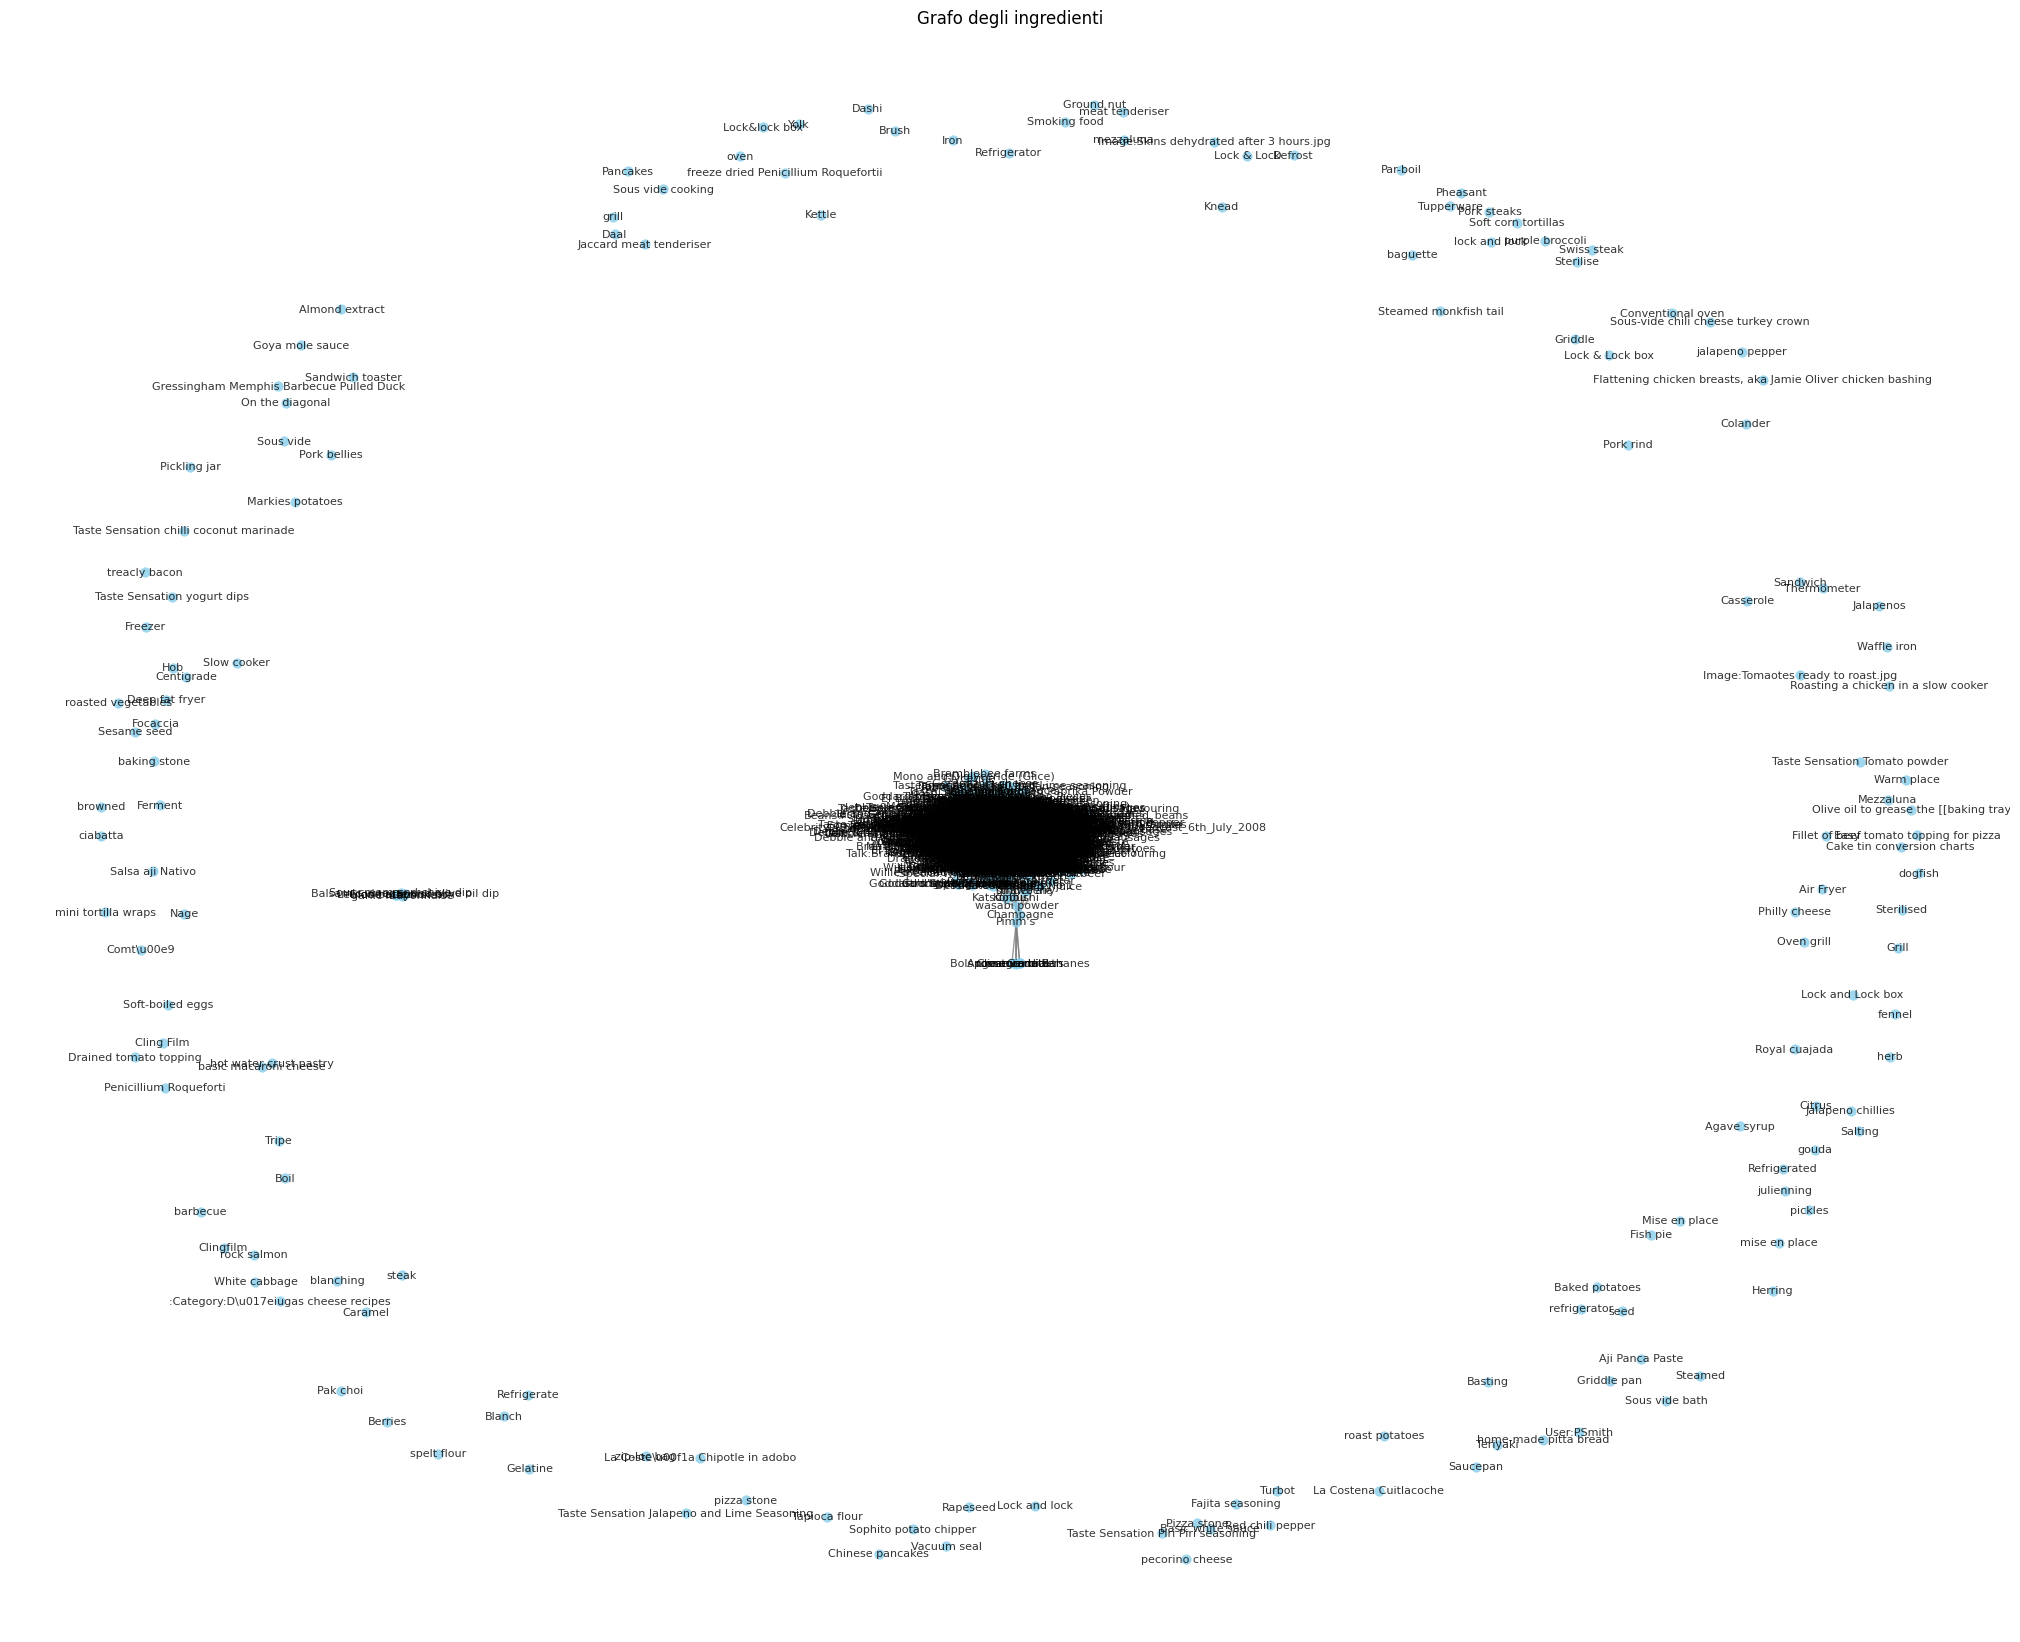

In [ ]:
pos = nx.spring_layout(G)

plt.figure(figsize=(20, 16))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_size=50,
    font_size=8,
    alpha=0.8,
    node_color="skyblue",
    edge_color="grey",
    linewidths=0.2,
)
plt.title("Grafo degli ingredienti")
plt.axis("off")
plt.show()

In [ ]:
# Save graph
with open("Graph_ingredients.pkl", "wb") as f:
    pickle.dump(G, f)

In [ ]:
# LOAD THE GRAPH
with open("Graph_ingredients.pkl", "rb") as f:
    G_ingredients = pickle.load(f)

In [ ]:
nodes_to_remove = ["Dried", "Juice", "Zest"]

# Check if the nodes exist in the graph before removing
for node in nodes_to_remove:
    if node in G.nodes():
        G.remove_node(node)
    else:
        print(f"The node {node} doesn't exist in the graph.")

In [ ]:
# sorted edges in descendent order
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)

# First 50 edges
top_50_edges = sorted_edges[:50]

print(top_50_edges)

[('Garlic', 'Olive oil', {'weight': 436}), ('Salt', 'Olive oil', {'weight': 374}), ('Sea Salt', 'Freshly ground black pepper', {'weight': 371}), ('Garlic', 'Salt', {'weight': 348}), ('Freshly ground black pepper', 'Olive oil', {'weight': 340}), ('Sea Salt', 'Olive oil', {'weight': 332}), ('Pepper', 'Salt', {'weight': 297}), ('Onion', 'Olive oil', {'weight': 291}), ('Garlic', 'Onion', {'weight': 286}), ('Salt', 'Onion', {'weight': 275}), ('Tomatoes', 'Olive oil', {'weight': 218}), ('Butter', 'Salt', {'weight': 215}), ('Sea Salt', 'Garlic', {'weight': 208}), ('Parsley', 'Olive oil', {'weight': 199}), ('Freshly ground black pepper', 'Onion', {'weight': 186}), ('Garlic', 'Tomatoes', {'weight': 180}), ('Garlic', 'Freshly ground black pepper', {'weight': 177}), ('Butter', 'Olive oil', {'weight': 165}), ('Salt', 'Tomatoes', {'weight': 164}), ('Salt', 'Onions', {'weight': 164}), ('Salt', 'Parsley', {'weight': 161}), ('Sea Salt', 'Onion', {'weight': 158}), ('Cloves', 'Garlic', {'weight': 156}),

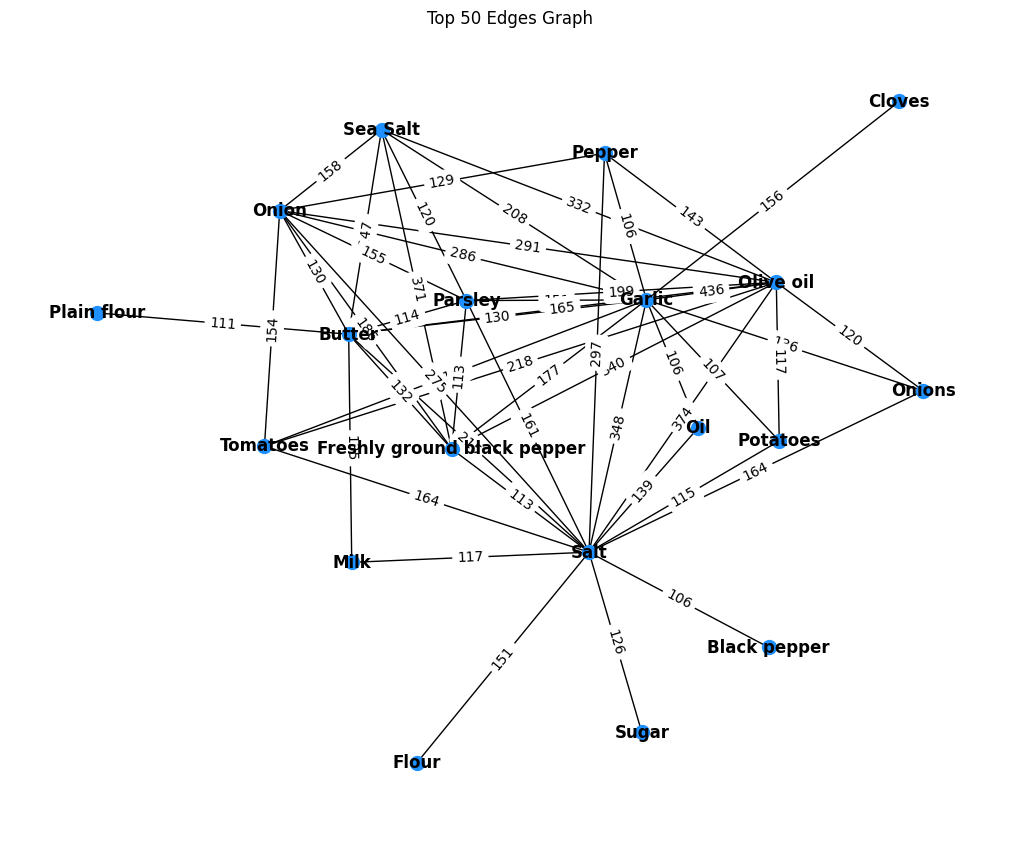

In [ ]:
# Create an empty graph
G_top_50 = nx.Graph()

# Add edges from the top 50 edges list
for edge in top_50_edges:
    node1, node2, weight = edge
    G_top_50.add_edge(node1, node2, weight=weight["weight"])

plt.figure(figsize=(10, 8))  # Set the size of the figure

# Draw the graph
pos = nx.kamada_kawai_layout(G_top_50)

edge_labels = {(u, v): d["weight"] for u, v, d in G_top_50.edges(data=True)}
nx.draw(
    G_top_50,
    pos,
    with_labels=True,
    node_color="dodgerblue",
    node_size=100,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(G_top_50, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Top 50 Edges Graph")
plt.show()

### Largest component of the Ingredients Graph

In [ ]:
largest_component = max(nx.connected_components(G_ingredients), key=len)
G_ing_sub = G_ingredients.subgraph(largest_component)

In [ ]:
pos = nx.kamada_kawai_layout(G_ing_sub)

plt.figure(figsize=(15, 8))
nx.draw(
    G_ing_sub,
    pos=pos,
    with_labels=True,
    node_size=50,
    font_size=8,
    alpha=0.8,
    node_color="skyblue",
    edge_color="grey",
    linewidths=0.2,
)
plt.title("Grafo degli ingredienti")
plt.axis("off")
plt.show()

In [ ]:
number_of_nodes = len(G_ing_sub.nodes)
print("Number of nodes in the network:", number_of_nodes)

Number of nodes in the network: 2843


In [ ]:
number_of_links = len(G_ing_sub.edges())
print("Number of links in the network:", number_of_links)

Number of links in the network: 79573


### Creating Recipes Graph

In [7]:
# Delete duplicate rows
duplicate_rows = recipes_data[recipes_data.duplicated(subset="Recipe")]
print(duplicate_rows)

Empty DataFrame
Columns: [Recipe, total_calories, portion_calories, difficulty, servings, total_time, prep_time, cook_time, ingredients]
Index: []


In [ ]:
recipes_data.drop_duplicates(subset="Recipe")

Recipe  total_calories  \
0                        Barbecued beef - Chinese style          1171.0   
1              Beef Massaman curry (slow cooker recipe)          6047.0   
2                             Black bean prawn stir fry          1836.0   
3                                    Braised aubergines          1021.0   
4                                Cajun Chicken Stir Fry           467.0   
...                                                 ...             ...   
3477                                   Tomato casserole           238.0   
3483                               'Roast' chicken (SV)          1512.0   
3494                                   4 hour lamb stew          2621.0   
3505  Airfryed meatballs and bacon with tomatoes and...           465.0   
3506                        Tave me presh (Baked leeks)          2858.0   

      portion_calories  difficulty     servings              total_time  \
0                292.0         1.0   Serves 4\n    3 hours 20 minutes\n   
1               1511.0         2.0          4\n   8 hours, 15 minutes\n   
2                459.0         2.0  Serves 4\n            30 minutes\n    
3                255.0         1.0  Serves 4\n            15 minutes\n    
4                 23.0         1.0   Serves 2\n   3 hours, 17 minutes\n   
...                ...         ...          ...                     ...   
3477              59.0         1.0  Serves 4\n                1 hour\n    
3483             378.0         2.0   Serves 4\n   6 hours, 15 minutes\n   
3494             436.0         1.0   Serves 6\n   4 hours, 15 minutes\n   
3505             232.0         1.0   Serves 2\n            25 minutes\n   
3506             714.0         2.0  Serves 4\n     1 hour 25 minutes\n    

                  prep_time             cook_time  \
0       3 hours 5 minutes\n          15 minutes\n   
1              15 minutes\n             8 hours\n   
2             20 minutes\n          10 minutes\n    
3              5 minutes\n          10 minutes\n    
4      3 hours, 5 minutes\n          12 minutes\n   
...                     ...                   ...   
3477          10 minutes\n          50 minutes\n    
3483           15 minutes\n             6 hours\n   
3494           15 minutes\n             4 hours\n   
3505           10 minutes\n          15 minutes\n   
3506          10 minutes\n   1 hour 15 minutes\n    

                                            ingredients  
0     ['braising steak', 'dark soy sauce', 'Garlic',...  
1     ['New Potatoes', 'Ghee', 'Vegetable oil', 'Mas...  
2     ['king prawns', 'Garlic', 'Ginger', 'chillies'...  
3     ['aubergines', 'ginger', 'Garlic', 'light soy ...  
4     ['Chicken breast', 'lime juice', 'Taste Sensat...  
...                                                 ...  
3477  ['Olive oil', 'Flat leaved parsley', 'Tomatoes...  
3483  ['Chicken', 'How to spatchcock a chicken', 'Oi...  
3494  ['Lamb', 'Olive oil', 'Frying', 'Home smoked b...  
3505  ['Meat balls', 'Bramblebee Farms', 'Taste Sens...  
3506  ['Olive oil', 'Leeks', 'Onion', 'Minced', 'Lam...  

[2487 rows x 9 columns]

In [ ]:
G_recipes = nx.Graph()

# Add nodes with attributes
for index, row in recipes_data.iterrows():
    recipe_name = row["Recipe"]
    recipe_attributes = {
        "Total_calories": row["total_calories"],
        "Portion_calories": row["portion_calories"],
        "Difficulty": row["difficulty"],
        "Servings": row["servings"],
        "Total_time": row["total_time"],
        "Prep_time": row["prep_time"],
        "Cook_time": row["cook_time"],
        "Ingredients": row["ingredients"],
    }
    G_recipes.add_node(recipe_name, **recipe_attributes)

# Nodes connection based on common ingredients
for recipe1, recipe2 in itertools.combinations(G_recipes.nodes(), 2):
    ingredients1 = set(
        recipes_data.loc[recipes_data["Recipe"] == recipe1, "ingredients"].iloc[0]
    )
    ingredients2 = set(
        recipes_data.loc[recipes_data["Recipe"] == recipe2, "ingredients"].iloc[0]
    )

    common_ingredients = ingredients1 & ingredients2

    if common_ingredients:
        # Weight assignment based on the number of common ingredients
        weight = len(common_ingredients)
        G_recipes.add_edge(recipe1, recipe2, weight=weight)

Adding Country as attribute of the node

In [ ]:
# Directory containing folders with recipes divided by country
recipes_directory = "recipes"

# Traverse through all nodes in the graph
for node in G_recipes.nodes():
    print(node)
    # Name of the node
    recipe_name = node
    recipe_name = recipe_name.replace(" ", "_")

    # Check in all folders if the recipe is present
    for country_folder in os.listdir(recipes_directory):
        country_folder_path = os.path.join(recipes_directory, country_folder)
        print(country_folder_path)
        # Check if it's a directory
        if os.path.isdir(country_folder_path):
            # Check if the recipe is present in the country folder
            if os.path.exists(os.path.join(country_folder_path, f"{recipe_name}.txt")):
                print("")
                # Add the "Country" attribute to the node with the name of the country
                G_recipes.nodes[node]["Country"] = re.split(r"[_\s]+", country_folder)[
                    0
                ]
                break  # Exit the loop if a match is found

In [19]:
# LOAD THE GRAPH
with open("/content/Graph_recipes.pkl", "rb") as f:
    G_recipes = pickle.load(f)

# Edges and nodes number
print(f"Number of nodes: {G_recipes.number_of_nodes()}")
print(f"Number of edges: {G_recipes.number_of_edges()}")

Number of nodes: 2429
Number of edges: 1138633


Visualize the nodes' attributes to check if every step was executed correctly

In [20]:
set(np.array([list(G_recipes.nodes[n].keys()) for n in G_recipes.nodes()]).flatten())

{'Cook_time',
 'Country',
 'Difficulty',
 'Ingredients',
 'Portion_calories',
 'Prep_time',
 'Servings',
 'Total_calories',
 'Total_time'}

### Largest component of the Recipes Graph

In [17]:
largest_component = max(nx.connected_components(G_recipes), key=len)
G_rec_sub = G_recipes.subgraph(largest_component)

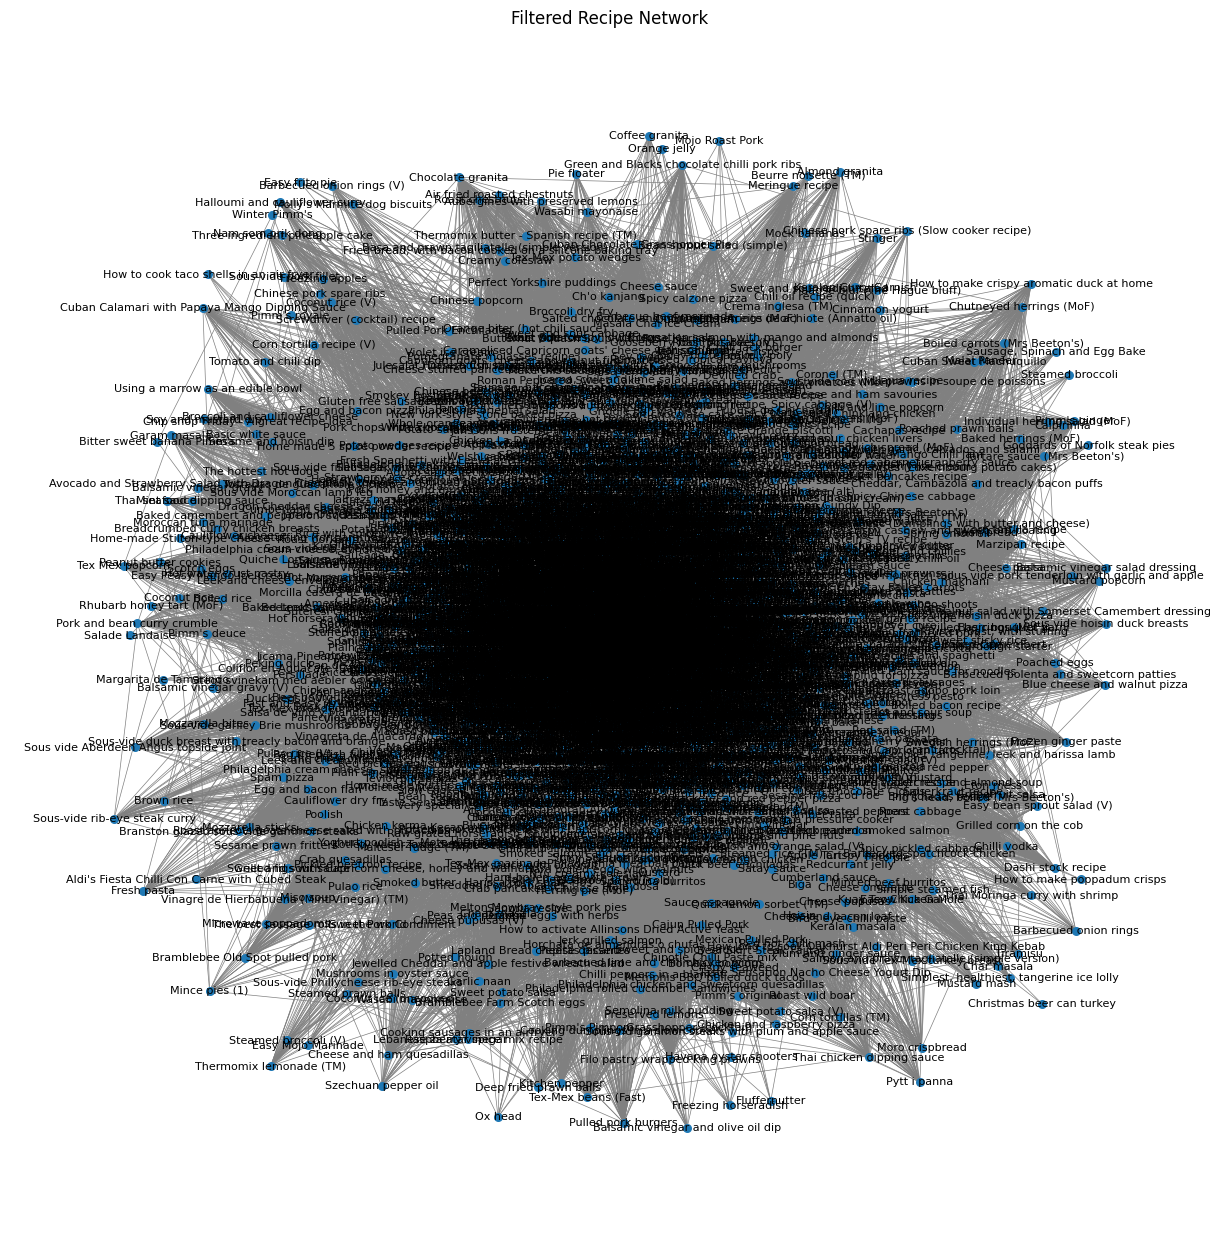

In [18]:
# Different layout and visualization adjustments
pos = nx.spring_layout(G_rec_sub, k=0.5, iterations=20)

plt.figure(figsize=(12, 12))
nx.draw(
    G_rec_sub,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

Now i need a scientific paragraph for the graphs creation
The graphs created are one with ingredients as nodes, connected if they are in the same recipe (and weighted if the are in more recipes together) while the other one is with the recipes as graph's node, connected if they share one or more ingredients

In [44]:
# sorted edges in descendent order
sorted_edges = sorted(G_recipes.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)

# First 50 edges
top_50_edges = sorted_edges[:50]

print(top_50_edges)

[('Chili con carne numero uno', 'Chilli cin carne numero uno (sous vide recipe)', {'weight': 27}), ('Chicken kadra with Chickpeas, peppers and onions (slow cooker recipe)', 'Chicken kadra with Chickpeas, red peppers and raisins', {'weight': 25}), ('Chicken biriani', 'Lamb biriani', {'weight': 24}), ('Moroccan chickpea, lentil and spinach stew', 'Moroccan chickpea, lentil and spinach stew (V)', {'weight': 24}), ('Guinness lamb shanks with dark sticky gravy', 'Lamb shanks in porter with dark sticky gravy', {'weight': 23}), ('Cochinita pibil', 'Cochinita pibil (slow cooker recipe)', {'weight': 22}), ('Chicken with pumpkins seeds and peanut butter', 'Chicken with pumpkins seeds and peanut butter (slow cooker recipe)', {'weight': 22}), ('Spicy vegetable samosa filling', 'Spicy vegetable samosa filling (V)', {'weight': 21}), ("Beetroot and bitter salad leaf risotto dressed with goats' cheese", "Beetroot and bitter salad leaf risotto dressed with goats' cheese (V)", {'weight': 21}), ('Couscou

('Basic meatballs', 'Spicy meatballs', {'weight': 18})

('Traditional meat paella', 'Traditional seafood paella', {'weight': 19})

('Chingri malai roti', 'Crayfish and coconut rice cake with hot chillies', {'weight': 17})

('Chingri malai roti', 'King prawn and coconut roti with tomatoes, chillies and ginger', {'weight': 16})

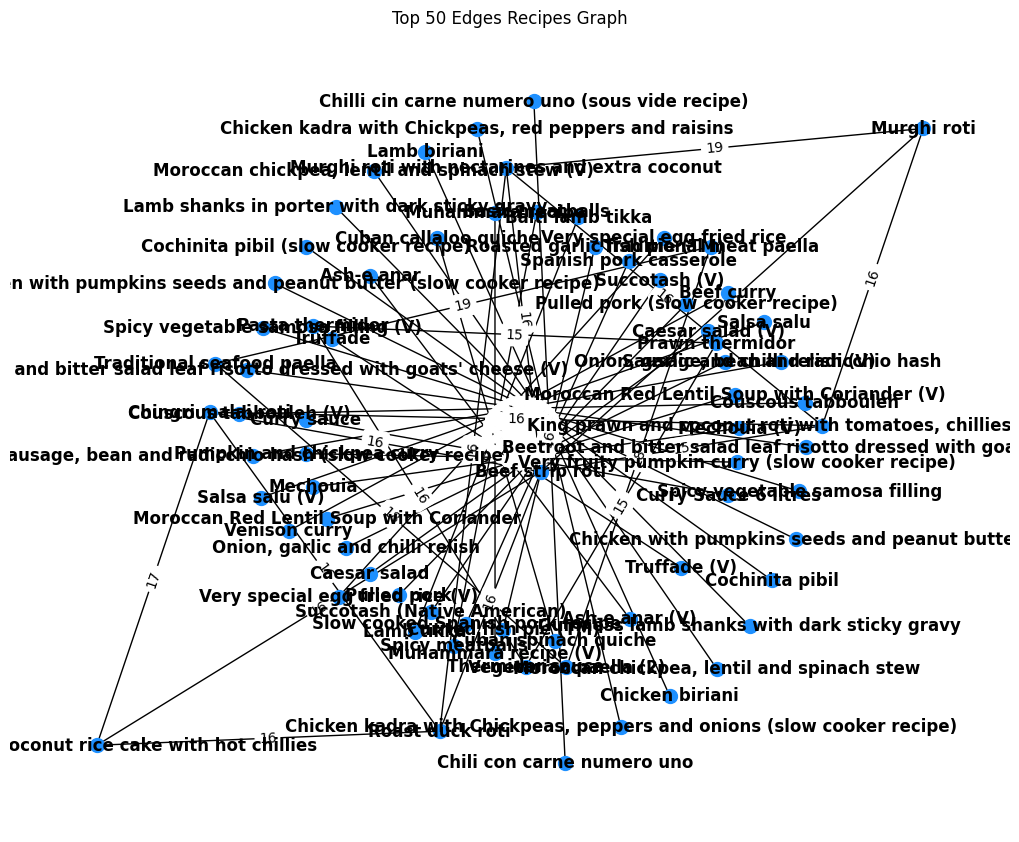

In [51]:
#  Create an empty graph
G_top_50_recipes = nx.Graph()

# Add edges from the top 50 edges list
for edge in top_50_edges:
    node1, node2, weight = edge
    G_top_50_recipes.add_edge(node1, node2, weight=weight["weight"])

# Nodes to be colored differently
specific_nodes = [1, 3]

# Define colors for nodes
node_colors = ['red' if node in specific_nodes else 'blue' for node in G.nodes()]


plt.figure(figsize=(10, 8))  # Set the size of the figure

# Draw the graph
pos = nx.kamada_kawai_layout(G_top_50_recipes)

edge_labels = {(u, v): d["weight"] for u, v, d in G_top_50_recipes.edges(data=True)}
nx.draw(
    G_top_50_recipes,
    pos,
    with_labels=True,
    node_color="dodgerblue",
    node_size=100,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(G_top_50_recipes, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Top 50 Edges Recipes Graph")
plt.show()

### to delete

In [ ]:
# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    unique_ingredients = set()  # Set so we just have unique values

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            unique_ingredients.add(ingredient)  # Add unique ingredient to the list

    # Creation of weighted edges bewteen the unique ingredients
    for i, ingr1 in enumerate(unique_ingredients):
        for ingr2 in list(unique_ingredients)[
            i + 1 :
        ]:  # No confront between edges already confronted
            if graph.has_edge(ingr1, ingr2):
                graph[ingr1][ingr2][
                    "weight"
                ] += 1  # If edge already exists increment weight
                for u, v, d in graph.edges(data=True):
                    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
            else:
                graph.add_edge(
                    ingr1, ingr2, weight=1
                )  # Otherwise new edge with weight 1

In [ ]:
# Initialize an undirected graph
G_recipes = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph
                    for ingredient in ingredients:
                        # Check for non-ASCII characters and skip adding those nodes
                        if all(ord(char) < 128 for char in ingredient):
                            if not G_recipes.has_node(ingredient):
                                G_recipes.add_node(ingredient)

                            # Add an edge between the ingredient and the recipe
                            add_edges(G_recipes, title, [ingredient], country)

# Filter edges based on edge weight threshold
threshold_weight = 1

filtered_edges = [
    (u, v) for u, v, d in G_recipes.edges(data=True) if d["weight"] > threshold_weight
]
for u, v, d in G_recipes.edges(data=True):
    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
# Create a subgraph containing only filtered edges and their associated nodes
G_rec_sub = G_recipes.edge_subgraph(filtered_edges)

print("Nodes in the subgraph:", G_rec_sub.number_of_nodes())
print("Edges in the subgraph:", G_rec_sub.number_of_edges())

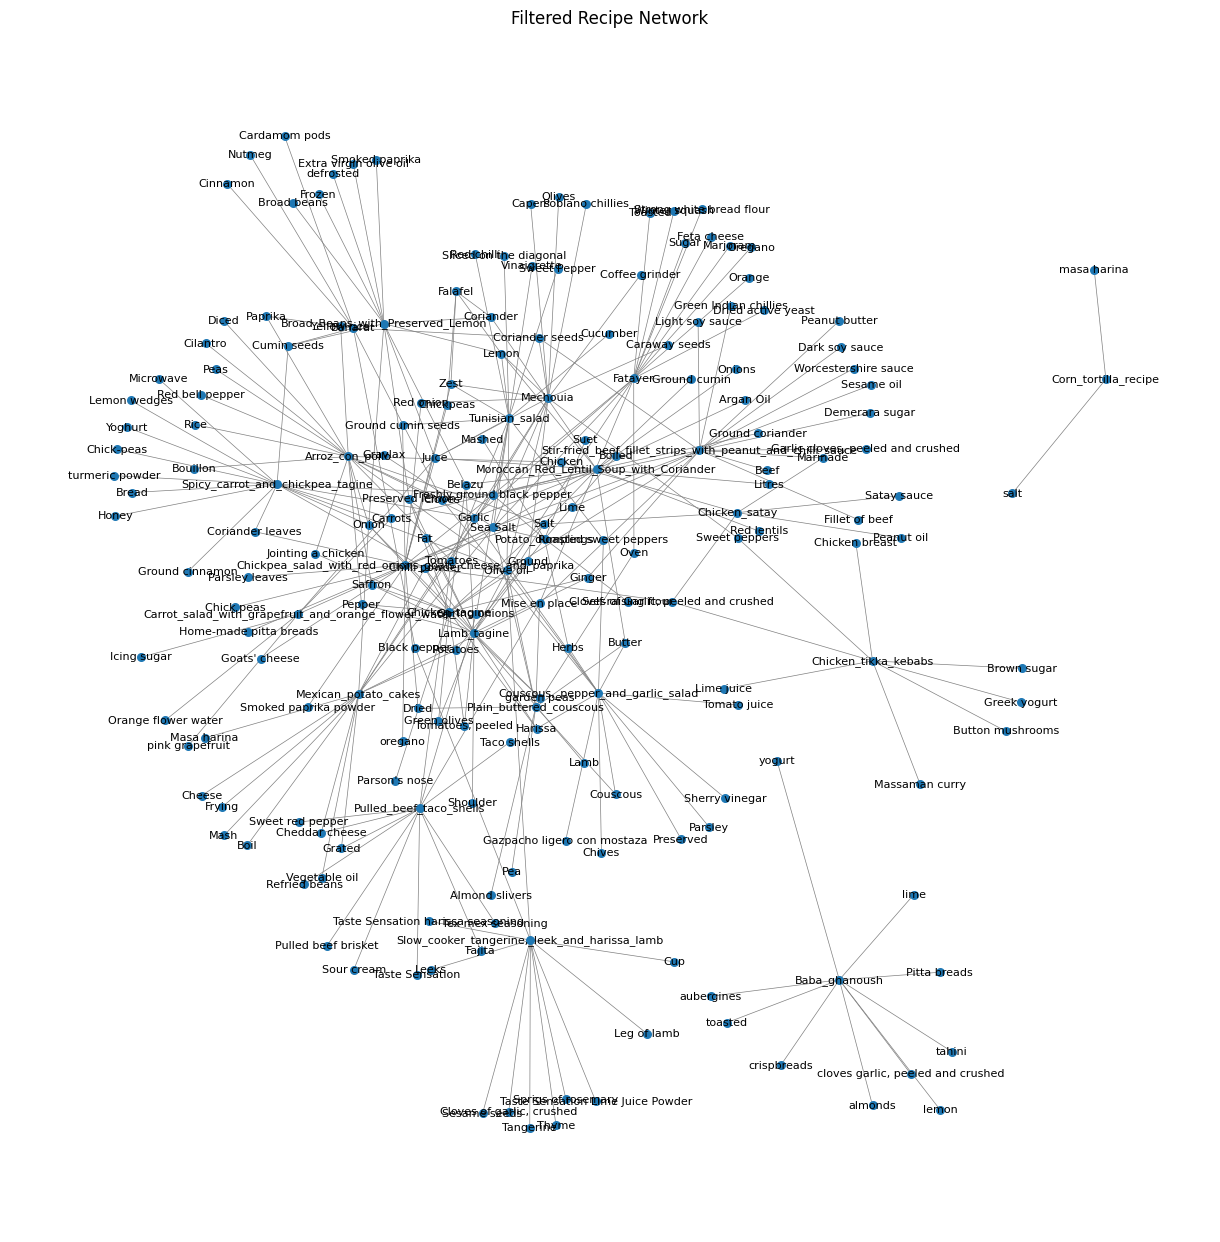

In [ ]:
pos = nx.spring_layout(G_rec_sub, k=0.15, iterations=20)

plt.figure(figsize=(12, 12))
nx.draw(
    G_rec_sub,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

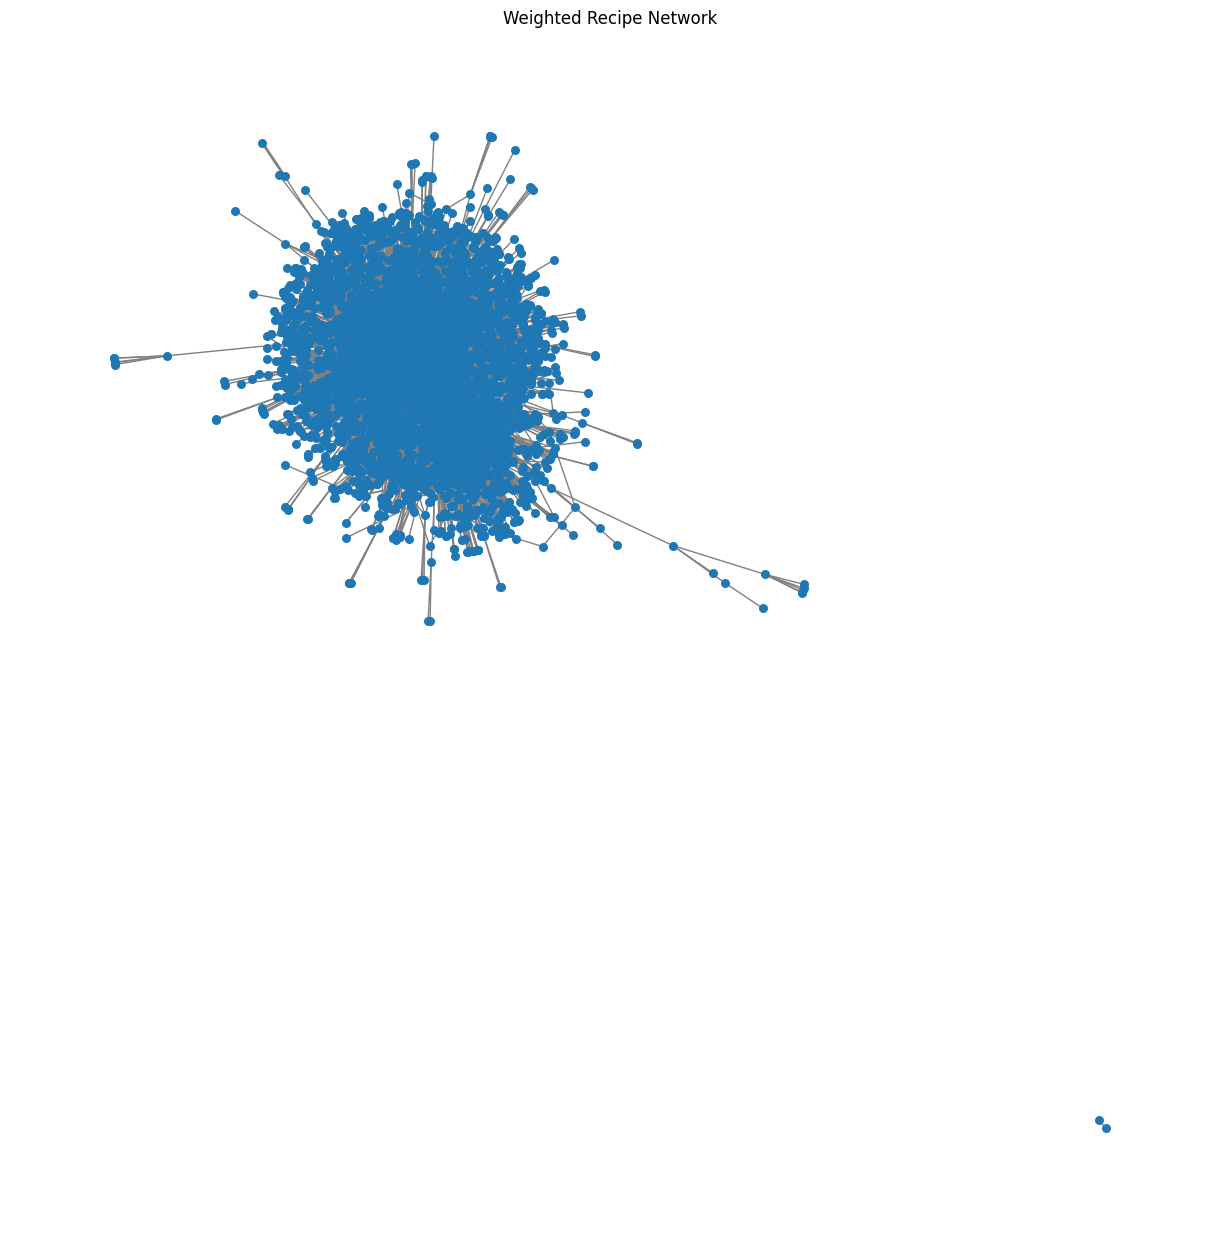

In [ ]:
# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return ingredients  # Return a list of ingredients
    else:
        return []


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    ingredient_count = {}  # Dictionary to count ingredient occurrences

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            # Count occurrences of each ingredient across different recipes
            if ingredient in ingredient_count:
                ingredient_count[ingredient] += 1
            else:
                ingredient_count[ingredient] = 1

    for ingredient, count in ingredient_count.items():
        if not graph.has_node(ingredient):
            graph.add_node(ingredient)

        # Add an edge between the recipe and the ingredient with weight (based on count)
        graph.add_edge(recipe, ingredient, weight=count)


# Initialize an undirected graph
graph = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph with weighted edges
                    add_edges(graph, title, ingredients, country)

# Plotting the weighted graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph)
edge_weights = [graph[u][v]["weight"] for u, v in graph.edges]

nx.draw(
    graph,
    pos,
    node_size=30,
    font_color="black",
    width=edge_weights,  # Use edge weights for varying edge thickness
    edge_color="gray",
)
plt.title("Weighted Recipe Network")
plt.show()

# Community Analysis

## Ingredients Analysis

In [ ]:
# Louvain Algorithm
louvain_partition = community_louvain.best_partition(G_ing_sub)
louvain_modularity = community_louvain.modularity(louvain_partition, G_ing_sub)
print(f"Louvain Modularity: {louvain_modularity}")

# Girvan-Newman Algorithm (Edge Betweenness)
communities_generator = nx.algorithms.community.girvan_newman(G_ing_sub)
top_level_communities = next(communities_generator)
girvan_newman_modularity = nx.algorithms.community.quality.modularity(
    G_ing_sub, top_level_communities
)
print(f"Girvan-Newman Modularity: {girvan_newman_modularity}")

# Label Propagation
label_propagation_communities = list(
    nx.algorithms.community.label_propagation.label_propagation_communities(G_ing_sub)
)
label_propagation_modularity = nx.algorithms.community.quality.modularity(
    G_ing_sub, label_propagation_communities
)
print(f"Label Propagation Modularity: {label_propagation_modularity}")

Louvain Modularity: 0.2378992885707619
Girvan-Newman Modularity: 0.00011974741886673157
Label Propagation Modularity: 0.0002394711616554189


In [ ]:
num_communities = len(set(louvain_partition.values()))
print(f"Number of communities: {num_communities}")
print(f"Modularity: {louvain_modularity}")

Number of communities: 10
Modularity: 0.2378992885707619


Community 0: 737 nodes
Community 1: 539 nodes
Community 2: 622 nodes
Community 3: 780 nodes
Community 4: 90 nodes
Community 5: 46 nodes
Community 6: 7 nodes
Community 7: 17 nodes
Community 8: 7 nodes
Community 9: 3 nodes


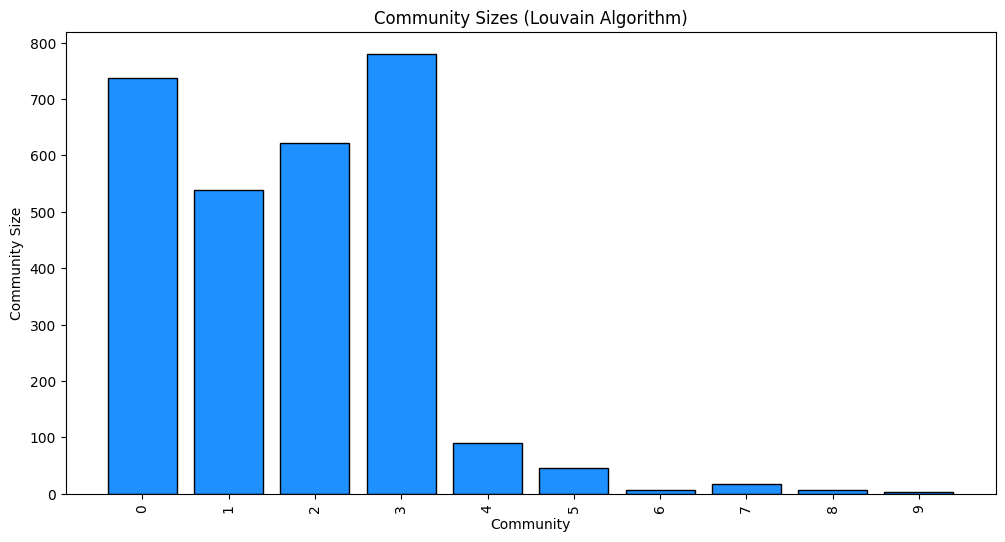

In [ ]:
# Create a dictionary to count the sizes of each community
community_sizes = {}
for node, community_id in louvain_partition.items():
    if community_id in community_sizes:
        community_sizes[community_id] += 1
    else:
        community_sizes[community_id] = 1

# Community sizes
for community_id in sorted(community_sizes.keys()):
    size = community_sizes[community_id]
    print(f"Community {community_id}: {size} nodes")

community_sizes_values = list(community_sizes.values())
community_sizes_labels = list(community_sizes.keys())

plt.figure(figsize=(12, 6))
plt.bar(
    community_sizes_labels,
    community_sizes_values,
    color="dodgerblue",
    edgecolor="black",
)
plt.title("Community Sizes (Louvain Algorithm)")
plt.xlabel("Community")
plt.ylabel("Community Size")
plt.xticks(community_sizes_labels, rotation="vertical")
plt.show()

Modularity: 0.24219027808811924


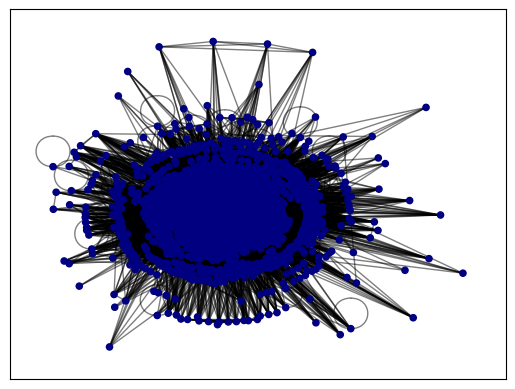

In [ ]:
from networkx.algorithms.community.quality import modularity

partition = nx.community.louvain_communities(G_ing_sub)

# Compute the Louvain communities within the 'east' subgraph
communities = list(nx.community.louvain_communities(G_ing_sub))

# Ensure there are multiple communities
if len(communities) > 1:
    # Calculate the modularity for the partition using nx.community.modularity
    mod = modularity(G_ing_sub, communities)

    # Print the modularity value
    print(f"Modularity: {mod}")

    # Use the Kamada-Kawai layout for better node positioning
    pos = nx.kamada_kawai_layout(G_ing_sub)

    # Drawing with community-based colors
    size = float(len(communities))
    count = 0.0
    for com in communities:
        count += 1.0
        list_nodes = [node for node in com]

        # Draw nodes with positions
        nx.draw_networkx_nodes(
            G_ing_sub,
            pos,
            nodelist=list_nodes,
            node_size=20,
            cmap=plt.get_cmap("jet", len(communities)),
            node_color=[count / size] * len(list_nodes),
        )

    nx.draw_networkx_edges(G_ing_sub, pos, alpha=0.5)

    plt.show()
else:
    print("No valid communities found.")

## Recipes Analysis

In [53]:
from networkx.algorithms import community

# Group nodes into communities based on the "Country" attribute
country_communities = {}
for node, data in G_recipes.nodes(data=True):
    country = data.get("Country")
    if country not in country_communities:
        country_communities[country] = [node]
    else:
        country_communities[country].append(node)

# Create a subgraph for each country community
subgraphs = {}
for country, nodes in country_communities.items():
    subgraph = G_recipes.subgraph(nodes)
    subgraphs[country] = subgraph

modularity_values = {}
tot=0
for country, subgraph in subgraphs.items():
    # Calculate modularity only if the subgraph has nodes and edges
    if subgraph.number_of_nodes() > 0 and subgraph.number_of_edges() > 0:
        communities_generator = list(community.greedy_modularity_communities(subgraph))
        modularity = community.modularity(subgraph, communities_generator)
        modularity_values[country] = modularity
        # print(f"Number of nodes {subgraph.number_of_nodes()} in {country} community")
        tot += subgraph.number_of_nodes()
    else:
        print(f"Empty subgraph for country: {country}")

Empty subgraph for country: Vietnamese


In [33]:
# Print modularity values for each non-empty country community
for country, modularity in modularity_values.items():
    print(f"Country: {country} - Modularity: {modularity}")

Country: Chinese - Modularity: 0.31980169963024085
Country: British - Modularity: 0.12446090683306645
Country: Chilean - Modularity: 0.14797760558237663
Country: Cuban - Modularity: 0.10663710808487535
Country: Albanian - Modularity: 0.0
Country: Czech - Modularity: 0.0
Country: Danish - Modularity: 0.2439236111111111
Country: Dutch - Modularity: 0.0
Country: Ecuadorian - Modularity: 1.1102230246251565e-16
Country: Finnish - Modularity: 0.1505102040816327
Country: French - Modularity: 0.18229812550158808
Country: Algerian - Modularity: 0.029723079739095826
Country: Belgian - Modularity: 0.0
Country: Australian - Modularity: 0.14958448753462597
Country: German - Modularity: 0.09766855702583488
Country: Austrian - Modularity: 0.16959664183815176
Country: Greek - Modularity: 0.10291057508134963
Country: Armenian - Modularity: 0.09085937499999998
Country: Bulgarian - Modularity: -0.02102079395085063
Country: Hungarian - Modularity: 0.3994444444444444
Country: Indian - Modularity: 0.1525017

In [34]:
max_modularity = 0
country_with_max_modularity = ""

for country, modularity in modularity_values.items():
    if modularity > max_modularity:
        max_modularity = modularity
        country_with_max_modularity = country  # Update max modularity country

print(f"Country with maximum modularity: {country_with_max_modularity}")
print(f"Maximum modularity value: {max_modularity}")


Country with maximum modularity: Indonesian
Maximum modularity value: 0.43402777777777785


Hypothesis about this finding:

1. **Distinctive Cuisine Traits**: Indonesian cuisine may exhibit a unique and distinct set of recipes or ingredients that differentiate it significantly from other cuisines in the dataset. These distinct traits might contribute to a higher level of modularity, indicating a more separate or modular structure within the graph of recipes based on their country origins.

2. **Diverse Culinary Influence**: Indonesian cuisine might reflect a diverse range of influences, possibly incorporating various cooking styles, ingredients, or cultural culinary practices. This diversity could lead to a more modular structure in the recipe graph, indicating clear separations or clusters related to the cuisine's unique characteristics.

In [35]:
min_modularity = float('inf')
country_with_min_modularity = ""

for country, modularity in modularity_values.items():
    if modularity < min_modularity:
        min_modularity = modularity
        country_with_min_modularity = country  # Update min modularity country

print(f"Country with minimum modularity: {country_with_min_modularity}")
print(f"Minimum modularity value: {min_modularity}")


Country with minimum modularity: Bulgarian
Minimum modularity value: -0.02102079395085063


Hypothesis about this finding:

1. **Integration or Similarity with Other Cuisines**: Bulgarian cuisine might exhibit similarities with or be integrated into other neighboring or culturally similar cuisines. This integration could result in a negative modularity, indicating a less distinct or separate culinary structure within the recipe network.

2. **Shared Ingredients or Culinary Practices**: Bulgarian cuisine might share common ingredients or culinary practices with cuisines from nearby regions. These shared traits could lead to a lower modularity score, suggesting a more blended or less partitioned structure in the recipe graph.

In [37]:
from community import community_louvain

# Louvain Algorithm
louvain_partition = community_louvain.best_partition(G_rec_sub)
louvain_modularity = community_louvain.modularity(louvain_partition, G_rec_sub)
print(f"Louvain Modularity: {louvain_modularity}")

# Girvan-Newman Algorithm (Edge Betweenness)
communities_generator = nx.algorithms.community.girvan_newman(G_rec_sub)
top_level_communities = next(communities_generator)
girvan_newman_modularity = nx.algorithms.community.quality.modularity(
    G_rec_sub, top_level_communities
)
print(f"Girvan-Newman Modularity: {girvan_newman_modularity}")

# Label Propagation
label_propagation_communities = list(
    nx.algorithms.community.label_propagation.label_propagation_communities(G_rec_sub)
)

label_propagation_modularity = nx.algorithms.community.quality.modularity(
    G_rec_sub, label_propagation_communities
)
print(f"Label Propagation Modularity: {label_propagation_modularity}")

Louvain Modularity: 0.16638328240494862
Girvan-Newman Modularity: -1.6181642873590223e-13
Label Propagation Modularity: 3.4127406994279463e-06
